In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings

warnings.filterwarnings("ignore")

In [31]:
df = pd.read_csv('C:/Users/shail/Desktop/project/raw data/Device-2.csv')

df.columns = ['SNo','temp','hum','co','no2','pm2_5','pm10','date']
date = df['date']
df = df.drop(["SNo"],axis=1)
df['date'] = pd.to_datetime(df['date'])

In [32]:
df.head()

,temp,hum,co,no2,pm2_5,pm10,date
0,18,50,41,1.49,59,82,2020-01-11 17:07:49
1,18,50,41,1.50,59,82,2020-01-11 17:07:43
2,18,50,41,1.50,59,82,2020-01-11 17:07:39
3,18,50,41,1.50,60,83,2020-01-11 17:07:28
4,18,50,41,1.50,60,83,2020-01-11 17:07:24


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1089280 entries, 0 to 1089279
Data columns (total 7 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   temp    1089280 non-null  int64         
 1   hum     1089280 non-null  int64         
 2   co      1089280 non-null  int64         
 3   no2     1089280 non-null  float64       
 4   pm2_5   1089280 non-null  int64         
 5   pm10    1089280 non-null  int64         
 6   date    1089280 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 58.2 MB


In [34]:
df = df[(df['co'] > 0) & (df['no2'] > 0) & (df['pm2_5'] > 0) & (df['pm10'] > 0)]

In [35]:
temp_one_hr = round(df.resample('60min',on='date').temp.mean(),2)
hum_one_hr = round(df.resample('60min',on='date').hum.mean(),2)
co_one_hr = round(df.resample('60min',on='date').co.mean(),2)
no2_one_hr = round(df.resample('60min',on='date').no2.mean(),2)
pm2_5_one_hr = round(df.resample('60min',on='date').pm2_5.mean(),2)
pm10_one_hr = round(df.resample('60min',on='date').pm10.mean(),2)

one_hr_sample = pd.DataFrame({
    "TEMP":temp_one_hr,
    "HUM":hum_one_hr,
    "CO":co_one_hr,
    "NO2":no2_one_hr,
    "PM2.5":pm2_5_one_hr,
    "PM10":pm10_one_hr
})

one_hr_sample

,TEMP,HUM,CO,NO2,PM2.5,PM10
date,,,,,,
2019-09-13 05:00:00,23.00,89.00,15.76,19.25,28.34,39.31
2019-09-13 06:00:00,23.14,87.31,16.27,19.25,32.36,44.94
2019-09-13 07:00:00,24.23,83.01,16.25,19.26,58.58,82.12
2019-09-13 08:00:00,25.45,76.43,16.15,19.26,43.30,60.28
2019-09-13 09:00:00,27.85,66.55,16.39,19.25,48.00,66.76
...,...,...,...,...,...,...
2020-01-11 13:00:00,18.88,48.85,41.00,1.38,89.39,124.32
2020-01-11 14:00:00,19.03,47.54,41.00,1.43,77.89,108.28
2020-01-11 15:00:00,19.00,46.44,41.00,1.47,64.70,89.90


In [36]:
pm = one_hr_sample[['PM2.5']].copy()

In [37]:
pm

,PM2.5
date,
2019-09-13 05:00:00,28.34
2019-09-13 06:00:00,32.36
2019-09-13 07:00:00,58.58
2019-09-13 08:00:00,43.30
2019-09-13 09:00:00,48.00
...,...
2020-01-11 13:00:00,89.39
2020-01-11 14:00:00,77.89
2020-01-11 15:00:00,64.70


In [38]:
df = pm.copy()

In [39]:
df = df[-744:]
df

,PM2.5
date,
2019-12-11 18:00:00,NaN
2019-12-11 19:00:00,NaN
2019-12-11 20:00:00,NaN
2019-12-11 21:00:00,NaN
2019-12-11 22:00:00,NaN
...,...
2020-01-11 13:00:00,89.39
2020-01-11 14:00:00,77.89
2020-01-11 15:00:00,64.70


In [40]:
df.isna().sum()

PM2.5    259
dtype: int64

In [41]:
df = df.interpolate(method ='linear', limit_direction='both')

<AxesSubplot:xlabel='date'>

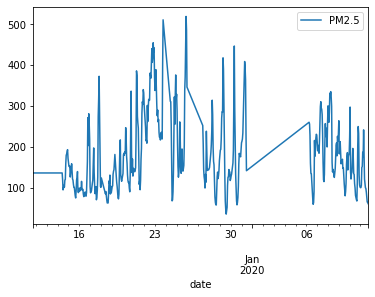

In [42]:
df.plot()

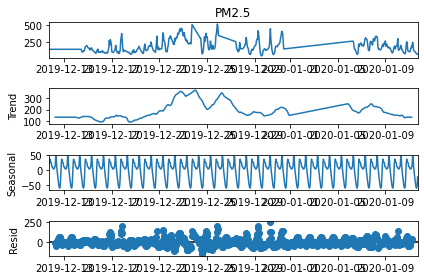

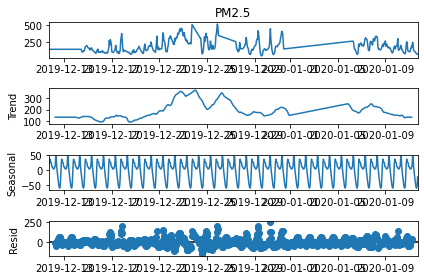

In [43]:
results = seasonal_decompose(df['PM2.5'], freq=24)
results.plot()

In [44]:
len(df)

744

In [45]:
train = df.iloc[:720]
test = df.iloc[720:]

scaler = MinMaxScaler()

In [46]:
df.head(), df.tail()

(                      PM2.5
 date                       
 2019-12-11 18:00:00  135.85
 2019-12-11 19:00:00  135.85
 2019-12-11 20:00:00  135.85
 2019-12-11 21:00:00  135.85
 2019-12-11 22:00:00  135.85,
                      PM2.5
 date                      
 2020-01-11 13:00:00  89.39
 2020-01-11 14:00:00  77.89
 2020-01-11 15:00:00  64.70
 2020-01-11 16:00:00  64.13
 2020-01-11 17:00:00  60.89)

In [47]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

scaled_train[:10]

array([[0.20817028],
       [0.20817028],
       [0.20817028],
       [0.20817028],
       [0.20817028],
       [0.20817028],
       [0.20817028],
       [0.20817028],
       [0.20817028],
       [0.20817028]])

# Recursive Strategy

In [48]:
n_input = 24
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train,length=n_input,batch_size=1)

generator[0]

(array([[[0.20817028],
         [0.20817028],
         [0.20817028],
         [0.20817028],
         [0.20817028],
         [0.20817028],
         [0.20817028],
         [0.20817028],
         [0.20817028],
         [0.20817028],
         [0.20817028],
         [0.20817028],
         [0.20817028],
         [0.20817028],
         [0.20817028],
         [0.20817028],
         [0.20817028],
         [0.20817028],
         [0.20817028],
         [0.20817028],
         [0.20817028],
         [0.20817028],
         [0.20817028],
         [0.20817028]]]),
 array([[0.20817028]]))

In [49]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               161600    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [50]:
model.fit(generator, epochs=10, verbose=1)

Epoch 1/10
696/696 [==============================] - 39s 11ms/step - loss: 0.0274
Epoch 2/10
696/696 [==============================] - 8s 11ms/step - loss: 0.0125
Epoch 3/10
696/696 [==============================] - 8s 12ms/step - loss: 0.0069
Epoch 4/10
696/696 [==============================] - 8s 11ms/step - loss: 0.0070
Epoch 5/10
696/696 [==============================] - 8s 11ms/step - loss: 0.0067
Epoch 6/10
696/696 [==============================] - 9s 13ms/step - loss: 0.0054
Epoch 7/10
696/696 [==============================] - 8s 12ms/step - loss: 0.0057
Epoch 8/10
696/696 [==============================] - 10s 15ms/step - loss: 0.0059
Epoch 9/10
696/696 [==============================] - 19s 27ms/step - loss: 0.0054
Epoch 10/10
696/696 [==============================] - 15s 22ms/step - loss: 0.0052


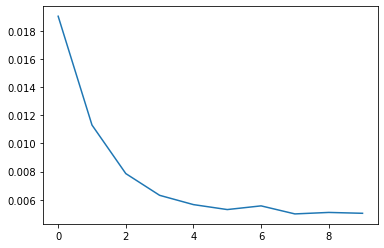

In [51]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [52]:
last_train_batch = scaled_train[-n_input:]

last_train_batch = last_train_batch.reshape((1,n_input, n_features))

model.predict(last_train_batch)

array([[0.2037776]], dtype=float32)

In [53]:
scaled_test[0], scaled_test[1]

(array([0.35087065]), array([0.44305029]))

In [54]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)
    
test_predictions

[array([0.2037776], dtype=float32),
 array([0.22840962], dtype=float32),
 array([0.24509431], dtype=float32),
 array([0.25677198], dtype=float32),
 array([0.2643522], dtype=float32),
 array([0.2687517], dtype=float32),
 array([0.27207196], dtype=float32),
 array([0.27637112], dtype=float32),
 array([0.27494478], dtype=float32),
 array([0.27132145], dtype=float32),
 array([0.2680323], dtype=float32),
 array([0.26538783], dtype=float32),
 array([0.26406756], dtype=float32),
 array([0.26424646], dtype=float32),
 array([0.26425496], dtype=float32),
 array([0.26317903], dtype=float32),
 array([0.26199132], dtype=float32),
 array([0.26047677], dtype=float32),
 array([0.2588995], dtype=float32),
 array([0.2571807], dtype=float32),
 array([0.25562662], dtype=float32),
 array([0.25432527], dtype=float32),
 array([0.25329953], dtype=float32),
 array([0.25389016], dtype=float32)]

In [55]:
test.head()

,PM2.5
date,
2020-01-10 18:00:00,204.77
2020-01-10 19:00:00,249.29
2020-01-10 20:00:00,231.89
2020-01-10 21:00:00,131.43
2020-01-10 22:00:00,106.64


In [56]:
true_predictions = scaler.inverse_transform(test_predictions)

test['recursive_predict'] = true_predictions

<AxesSubplot:xlabel='date'>

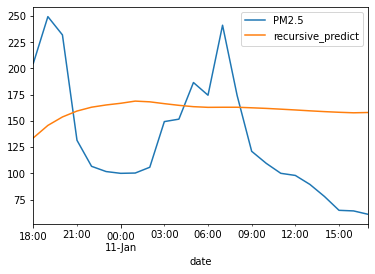

In [57]:
test.plot()

In [58]:
rmse = sqrt(mean_squared_error(test['PM2.5'], test['recursive_predict']))
print(rmse)

64.79172934026232


In [59]:
test

,PM2.5,recursive_predict
date,,
2020-01-10 18:00:00,204.77,133.728466
2020-01-10 19:00:00,249.29,145.624993
2020-01-10 20:00:00,231.89,153.683201
2020-01-10 21:00:00,131.43,159.323164
2020-01-10 22:00:00,106.64,162.984183
2020-01-10 23:00:00,101.65,165.109014
2020-01-11 00:00:00,99.95,166.712593
2020-01-11 01:00:00,100.23,168.788961
2020-01-11 02:00:00,105.74,168.100081


# Direct Startegy

In [60]:
def generate_data(data, n_input, month):
    X, y = [], []
    for i in range(0,len(data)-(n_input+month)):
            X.append(data[i:i+n_input])
            y.append(data[i+n_input+(month-1)])
    return np.array(X), np.array(y)

In [61]:
def model_predict(m_no, train_data, n_input, n_features):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, m_no)
    
    #print("MODEL : ", m_no)
    #print(X[0], y[0])
    
    model.fit(X, y, epochs=3, verbose=0)
    
    tX = train_data[-n_input:]
    
    tX = tX.reshape((1, n_input, n_features))
    
    res = model.predict(tX)
    
    return res[0]

In [62]:
n_input = 24
n_features = 1
test_predictions = []

for i in range(len(scaled_test)):
    test_predictions.append(model_predict(i+1,scaled_train,n_input, n_features))
    
test_predictions

[array([0.19500802], dtype=float32),
 array([0.20524038], dtype=float32),
 array([0.2266558], dtype=float32),
 array([0.21472184], dtype=float32),
 array([0.22468495], dtype=float32),
 array([0.24478033], dtype=float32),
 array([0.22560999], dtype=float32),
 array([0.22666274], dtype=float32),
 array([0.21643507], dtype=float32),
 array([0.25313112], dtype=float32),
 array([0.21256542], dtype=float32),
 array([0.24750528], dtype=float32),
 array([0.26019225], dtype=float32),
 array([0.24827155], dtype=float32),
 array([0.24651949], dtype=float32),
 array([0.26789093], dtype=float32),
 array([0.21673805], dtype=float32),
 array([0.22999421], dtype=float32),
 array([0.24383603], dtype=float32),
 array([0.19111298], dtype=float32),
 array([0.19738384], dtype=float32),
 array([0.22876795], dtype=float32),
 array([0.27867773], dtype=float32),
 array([0.24200073], dtype=float32)]

In [63]:
true_predictions = scaler.inverse_transform(test_predictions)

test['direct_predict'] = true_predictions

<AxesSubplot:xlabel='date'>

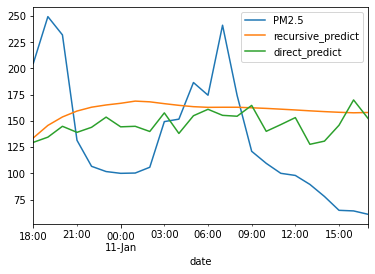

In [64]:
test.plot()

In [65]:
rmse = sqrt(mean_squared_error(test['PM2.5'], test['direct_predict']))
print(rmse)

58.90695107844079


In [66]:
test

,PM2.5,recursive_predict,direct_predict
date,,,
2020-01-10 18:00:00,204.77,133.728466,129.493026
2020-01-10 19:00:00,249.29,145.624993,134.434948
2020-01-10 20:00:00,231.89,153.683201,144.777950
2020-01-10 21:00:00,131.43,159.323164,139.014209
2020-01-10 22:00:00,106.64,162.984183,143.826092
2020-01-10 23:00:00,101.65,165.109014,153.531557
2020-01-11 00:00:00,99.95,166.712593,144.272856
2020-01-11 01:00:00,100.23,168.788961,144.781304
2020-01-11 02:00:00,105.74,168.100081,139.841648


# Direct Recursive Startegy

In [67]:
def generate_data(data, n_input, month):
    X, y = [], []
    for i in range(0,len(data)-(n_input+month)):
            X.append(data[i:i+n_input+(month-1)])
            y.append(data[i+n_input+(month-1)])
    return np.array(X), np.array(y)

In [68]:
def model_predict(m_no, train_data, n_input, n_features):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input+(m_no - 1), n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, m_no)
    #print(y.dtype)
    
    #print("Model No.  - ", m_no)
    #print(X[0], y[0])
    #print("SHAPE XY : ", X.shape, y.shape)
    
    model.fit(X, y, epochs=3, verbose=0)
    
    tX = train_data[-n_input:]
    tP = np.array(test_predictions)
    
    tX = np.concatenate((tX, tP), axis=None)
    
    #print("TYPE : ", type(tX), type(tP))
    
    #print("TX : ", tX)
        
    #print("SHAPE : " , tX.shape)
    
    tX = tX.reshape((1, tX.shape[0], n_features))
    
    res = model.predict(tX)
    
    return res[0]

In [69]:
n_input = 24
n_features = 1
test_predictions = []

for i in range(len(scaled_test)):
    pred = model_predict(i+1,scaled_train,n_input, n_features)
    test_predictions.append(pred)
    
test_predictions

[array([0.20540486], dtype=float32),
 array([0.19977652], dtype=float32),
 array([0.21011959], dtype=float32),
 array([0.22572972], dtype=float32),
 array([0.21575458], dtype=float32),
 array([0.2284969], dtype=float32),
 array([0.22634423], dtype=float32),
 array([0.25415042], dtype=float32),
 array([0.24200848], dtype=float32),
 array([0.25934738], dtype=float32),
 array([0.23445049], dtype=float32),
 array([0.25069433], dtype=float32),
 array([0.2718829], dtype=float32),
 array([0.2592009], dtype=float32),
 array([0.26990753], dtype=float32),
 array([0.25728735], dtype=float32),
 array([0.29379907], dtype=float32),
 array([0.28490555], dtype=float32),
 array([0.31273156], dtype=float32),
 array([0.2878201], dtype=float32),
 array([0.29853433], dtype=float32),
 array([0.30126914], dtype=float32),
 array([0.26562467], dtype=float32),
 array([0.29760987], dtype=float32)]

In [70]:
true_predictions = scaler.inverse_transform(test_predictions)

test['direct_recursive_predict'] = true_predictions

<AxesSubplot:xlabel='date'>

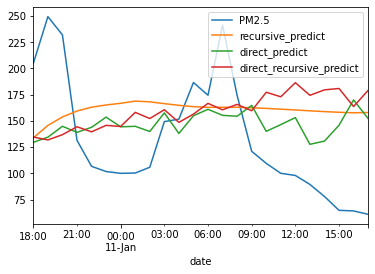

In [71]:
test.plot()

In [72]:
rmse = sqrt(mean_squared_error(test['PM2.5'], test['direct_recursive_predict']))
print(rmse)

70.7787578490106


In [73]:
test

,PM2.5,recursive_predict,direct_predict,direct_recursive_predict
date,,,,
2020-01-10 18:00:00,204.77,133.728466,129.493026,134.514387
2020-01-10 19:00:00,249.29,145.624993,134.434948,131.796064
2020-01-10 20:00:00,231.89,153.683201,144.777950,136.791458
2020-01-10 21:00:00,131.43,159.323164,139.014209,144.330682
2020-01-10 22:00:00,106.64,162.984183,143.826092,139.512991
2020-01-10 23:00:00,101.65,165.109014,153.531557,145.667145
2020-01-11 00:00:00,99.95,166.712593,144.272856,144.627472
2020-01-11 01:00:00,100.23,168.788961,144.781304,158.057029
2020-01-11 02:00:00,105.74,168.100081,139.841648,152.192834


# MIMO

In [74]:
def generate_data(data, n_input, n_output):
    X, y = [], []
    for i in range(0,len(data)-(n_input+n_output)):
            X.append(data[i:(i+n_input)])
            y.append(data[i+n_input: i+n_input+n_output])
    return np.array(X), np.array(y)

In [75]:
n_input = 24
n_features = 1
n_output = len(scaled_test)

X, y = generate_data(scaled_train, n_input, n_output)

In [76]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(n_output))
model.compile(optimizer='adam', loss='mse')

In [77]:
model.fit(X, y, epochs=3, verbose=0)

In [78]:
model.summary()

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_49 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_49 (Dense)             (None, 24)                4824      
Total params: 166,424
Trainable params: 166,424
Non-trainable params: 0
_________________________________________________________________


In [79]:
tX = scaled_train[-n_input:]
tX = tX.reshape((1, tX.shape[0], n_features))

res = model.predict(tX)

res = res.reshape((res.shape[1],1))

In [80]:
res.shape

(24, 1)

In [81]:
true_predictions = scaler.inverse_transform(res)

test['MIMO_predict'] = true_predictions

In [82]:
test

,PM2.5,recursive_predict,direct_predict,direct_recursive_predict,MIMO_predict
date,,,,,
2020-01-10 18:00:00,204.77,133.728466,129.493026,134.514387,150.718307
2020-01-10 19:00:00,249.29,145.624993,134.434948,131.796064,152.917358
2020-01-10 20:00:00,231.89,153.683201,144.777950,136.791458,156.510040
2020-01-10 21:00:00,131.43,159.323164,139.014209,144.330682,153.337051
2020-01-10 22:00:00,106.64,162.984183,143.826092,139.512991,152.706787
2020-01-10 23:00:00,101.65,165.109014,153.531557,145.667145,154.010254
2020-01-11 00:00:00,99.95,166.712593,144.272856,144.627472,150.856247
2020-01-11 01:00:00,100.23,168.788961,144.781304,158.057029,155.017349
2020-01-11 02:00:00,105.74,168.100081,139.841648,152.192834,150.105927


<AxesSubplot:xlabel='date'>

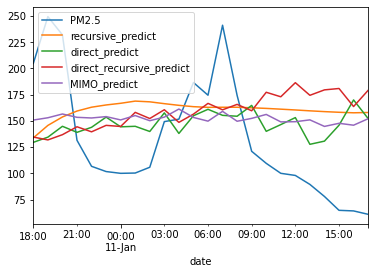

In [83]:
test.plot()

In [84]:
rmse = sqrt(mean_squared_error(test['PM2.5'], test['MIMO_predict']))
print(rmse)

57.097966337442145


# Direct MIMO

In [85]:
def generate_data(data, n_input, q_no, n_output):
    X, y = [], []
    for i in range(0,len(data)-(n_input + ((q_no-1)*n_output) + n_output)):
            X.append(data[i:(i+n_input)])
            y.append(data[i+n_input+((q_no-1)*n_output): i+n_input+((q_no-1)*n_output) + n_output])
    return np.array(X), np.array(y)

In [86]:
def model_predict(train_data, n_input, n_features, q_no, n_output):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(n_output))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, q_no, n_output)
    
    model.fit(X, y, epochs=3, verbose=0)
    
    tX = train_data[-n_input:]
    
    tX = tX.reshape((1, n_input, n_features))
    
    res = model.predict(tX)
    
    return res

In [87]:
n_input = 12
n_features = 1
test_predictions = []

n_output = 6

q = int(len(scaled_test)/n_output)


for i in range(q):
    pred = model_predict(scaled_train,n_input, n_features, i+1, n_output)
    test_predictions.append(pred)

test_predictions

[array([[0.22549511, 0.22077158, 0.24801466, 0.242464  , 0.23763065,
         0.24124986]], dtype=float32),
 array([[0.2507094 , 0.25591245, 0.25406978, 0.26152277, 0.26183084,
         0.26710963]], dtype=float32),
 array([[0.22996125, 0.23558581, 0.23877689, 0.2365713 , 0.2381722 ,
         0.23593211]], dtype=float32),
 array([[0.26336804, 0.26283878, 0.25020623, 0.25591174, 0.25966877,
         0.2548711 ]], dtype=float32)]

In [88]:
res = []

for i in test_predictions:
    for j in i:
        for k in j:
            res.append(k)

In [89]:
res = np.array(res)
res = res.reshape((res.shape[0],1))
res.shape

(24, 1)

In [90]:
true_predictions = scaler.inverse_transform(res)

test['Direct_MIMO_predict'] = true_predictions

In [91]:
test

,PM2.5,recursive_predict,direct_predict,direct_recursive_predict,MIMO_predict,Direct_MIMO_predict
date,,,,,,
2020-01-10 18:00:00,204.77,133.728466,129.493026,134.514387,150.718307,144.217377
2020-01-10 19:00:00,249.29,145.624993,134.434948,131.796064,152.917358,141.936050
2020-01-10 20:00:00,231.89,153.683201,144.777950,136.791458,156.510040,155.093643
2020-01-10 21:00:00,131.43,159.323164,139.014209,144.330682,153.337051,152.412842
2020-01-10 22:00:00,106.64,162.984183,143.826092,139.512991,152.706787,150.078476
2020-01-10 23:00:00,101.65,165.109014,153.531557,145.667145,154.010254,151.826447
2020-01-11 00:00:00,99.95,166.712593,144.272856,144.627472,150.856247,156.395126
2020-01-11 01:00:00,100.23,168.788961,144.781304,158.057029,155.017349,158.908035
2020-01-11 02:00:00,105.74,168.100081,139.841648,152.192834,150.105927,158.018082


<AxesSubplot:xlabel='date'>

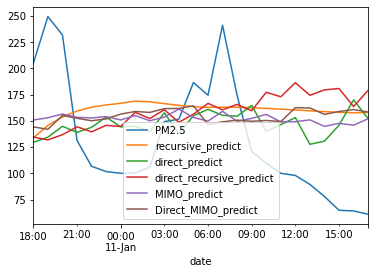

In [92]:
test.plot()

In [93]:
rmse = sqrt(mean_squared_error(test['PM2.5'], test['Direct_MIMO_predict']))
print(rmse)

62.61249799320998


In [94]:
rec_err = abs(test['PM2.5'] - test['recursive_predict'])
dir_err = abs(test['PM2.5'] - test['direct_predict'])
dir_rec_err = abs(test['PM2.5'] - test['direct_recursive_predict'])
mimo_err = abs(test['PM2.5'] - test['MIMO_predict'])
dir_mimo_err = abs(test['PM2.5'] - test['Direct_MIMO_predict'])

In [95]:
errors = pd.DataFrame({
    'Recursive':rec_err,
    'Direct':dir_err,
    'Direct Recursive':dir_rec_err,
    'MIMO':mimo_err,
    'Direct MIMO':dir_mimo_err
})

In [96]:
errors

,Recursive,Direct,Direct Recursive,MIMO,Direct MIMO
date,,,,,
2020-01-10 18:00:00,71.041534,75.276974,70.255613,54.051693,60.552623
2020-01-10 19:00:00,103.665007,114.855052,117.493936,96.372642,107.353950
2020-01-10 20:00:00,78.206799,87.112050,95.098542,75.379960,76.796357
2020-01-10 21:00:00,27.893164,7.584209,12.900682,21.907051,20.982842
2020-01-10 22:00:00,56.344183,37.186092,32.872991,46.066787,43.438476
2020-01-10 23:00:00,63.459014,51.881557,44.017145,52.360254,50.176447
2020-01-11 00:00:00,66.762593,44.322856,44.677472,50.906247,56.445126
2020-01-11 01:00:00,68.558961,44.551304,57.827029,54.787349,58.678035
2020-01-11 02:00:00,62.360081,34.101648,46.452834,44.365927,52.278082


<AxesSubplot:xlabel='date'>

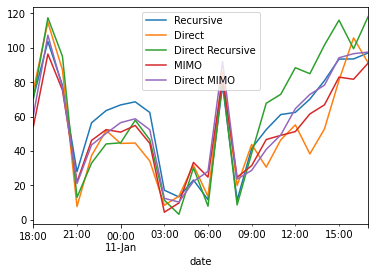

In [97]:
errors.plot()

In [98]:
len(scaled_test)

24